In [1]:
#image analysis
import sys
sys.path.append("../../")

import json
import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.save_folder =  "G:/DREAM/from_github/thesis/Intensity_paper/"

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib inline
#pympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip, marker, hatch, color, linestyles
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline

from alienlab.regression_func import residuals, exp_decay, regression_affine, regression_linear, get_affine_func


from mvgavg import mvgavg



from collections import OrderedDict

keys = list(linestyles.keys())


In [2]:
file_path = "Yuxi_nov_22/OJIP test paralell with Alienor, HL and Non-activated sample 11-03.xlsx"

In [3]:
def sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    y = F0 + Aoj*(1-np.exp(-koj*tdata))**soj + Aji*(1-np.exp(-kji*tdata))**sji +  Aip*(1-np.exp(-kip*tdata))**sip
    
    return y

def d1_sigmoidal_OJIP(A, k, s, tdata):
    y = A*s*k*(1-np.exp(-tdata*k))**(s-1)*np.exp(-tdata*k)
    return y

def d2_sigmoidal_OJIP(A, k, s, tdata):
    y = -(s*k*k*(1-np.exp(-tdata*k))**s*(np.exp(k*tdata)-s))/(np.exp(tdata*k)-1)**2
    return y



def diff_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d1_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d1_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d1_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    
def diff2_sigmoidal_OJIP(parameters, tdata):
    F0 = parameters[0]
    Aoj = parameters[1]
    koj = parameters[2]
    soj = parameters[3]
    Aji = parameters[4]
    kji = parameters[5]
    sji = parameters[6]
    Aip = parameters[7]
    kip = parameters[8]
    sip = parameters[9]
    
    yoj = d2_sigmoidal_OJIP(Aoj, koj, soj, tdata)
    yji = d2_sigmoidal_OJIP(Aji, kji, sji, tdata)
    yip = d2_sigmoidal_OJIP(Aip, kip, sip, tdata)
    return yoj + yji + yip
    

def multiexp_fit(f, N = 10, bode_folder =  "2022-07-29_16_33_bode_diagram" ):
    file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
    file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
    
    #(voltage, filter) = np.genfromtxt(glob.glob(f + "/*intensity_OJIP.txt")[0], delimiter = ',')
    
    with open(f + "/config.json", 'r') as j:
         contents = json.loads(j.read())
    voltage = np.max([contents['limit_blue'], contents['limit_red'], contents['limit_green'], contents['limit_purple']])
    filter = contents['actinic_filter']
    
    data_sequence = pd.read_csv(file_path)
    amp_seq = pd.read_csv(file2)

    V = VoltageIntensity(folder = bode_folder)#"2022-07-28_10_10_bode_diagram")2022-01-13_12_02_bode_diagram
    intensity = V.get_intensity_voltage('blue', int(filter), voltage/100)*1e6
    intensity_purple=  V.get_intensity_voltage('purple', int(filter), voltage/100)*1e6
    #fluo = amplitude

    time_array = np.array(data_sequence["time (s) intensity"])

    fluo = np.array(data_sequence["voltage (V) intensity"])
    blank = np.mean(fluo[0:10])
    fluo = fluo-blank
    fluo_ref = fluo/fluo.max()
    ind_ref = (fluo_ref>0.1)#*(time_array>4e-5)    
    
    
    binit = True
    t = mvgavg(time_array[ind_ref], N, binning = binit)
    y = mvgavg(fluo[ind_ref], N, binning = binit)
    #t = time_array[ind_ref]
    #y = fluo[ind_ref]
    t-=t[0]
    
    ind= np.unique(np.logspace(np.log10(1), np.log10(len(t)-1), 10000).astype(int))
    t = t[ind]
    y = y[ind]
    #poly = np.polyfit(np.log(t), y,20)
    #yp = np.polyval(poly, np.log(t))
    dF = fluo.max()-fluo.min()
    x0 = [fluo.min(), dF/2, 5E3, 1.24, dF/4, 0.06E3, 1.2, dF/4, 0.0023E3, 8.2]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = ([-1e5,-1e5, 0, 1,-1e5, 0, 1,-1e5, 0, 1], [1e5,1e5, 1e5, 20,1e5, 1e5, 20,1e5, 1e5, 20]),
                                args = (t, y, sigmoidal_OJIP))
    
    tau = parameters_estimated.x[2]
    ypred = sigmoidal_OJIP(parameters_estimated.x, t)
    return intensity, parameters_estimated.x, t, y, ypred, voltage, y.max(), intensity_purple, filter


def casual_multiexp(fluo, time):

    dF = fluo.max()-fluo.min()
    x0 = [fluo.min(), dF/2, 5E3, 1.24, dF/4, 0.06E3, 1.2, dF/4, 0.0023E3, 8.2]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = ([-1e5,-1e5, 0, 1,-1e5, 0, 1,-1e5, 0, 1], [1e5,1e5, 1e5, 20,1e5, 1e5, 20,1e5, 1e5, 20]),
                                args = (time, fluo, sigmoidal_OJIP))
    
    tau = parameters_estimated.x[2]
    ypred = sigmoidal_OJIP(parameters_estimated.x, t)
    return tau, ypred
    
    
def exp_decay(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    return A * (1 - np.exp(-xdata/tau))**1.24 + y0


def exp_decay_dual(parameters, xdata):
    '''
    Calculate an exponential decay of the form:
    S = a * exp(-xdata/b)
    '''
    A = parameters[0]
    tau = parameters[1]
    y0 = parameters[2]
    A2 = parameters[3]
    tau2 = parameters[4]
    return A * (1 - np.exp(-xdata/tau))**1.24 + A2 * (1 - np.exp(-xdata/tau2))**1.2+ y0


def get_fit(decay, time):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, 1/10, stop]#, start, 1/10]
    time = time-time[0]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    #if tau >  (second-first)//10: #if too high
    #    tau =  (second-first)//10
    #if tau < 3: #if too low, increase it
    #        tau = 5
    tau = parameters_estimated.x[1]
    pos_tau = find_nearest(time, tau)
    x0 = parameters_estimated.x #initial guess: parameters from previous fit
    #second fit
    parameters_estimated  = optimize.least_squares(residuals,  x0, bounds = (-1e9,1e9),
                                            args = (time[0:int(pos_tau*5)], decay[0: int(pos_tau*5)], exp_decay))
    return parameters_estimated.x

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

[80, 20, 30, 40, 50, 60, 70, 80, 90, 20, 30, 40, 50, 60, 70, 90]

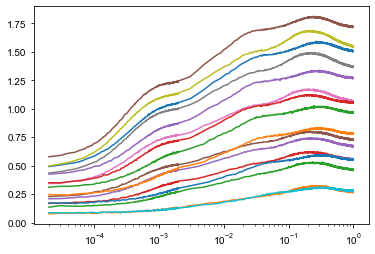

In [4]:
file = pd.read_excel(file_path, skiprows = 82, usecols = range(17))
keys = list(file.keys())
x = file[keys[0]].values
y_list=[]
amp_list = []
for i in range(1,len(keys)):
    y = file[keys[i]].values
    plt.semilogx(x,y)
    y_list.append(y)
    
    amp_list.append(int(keys[i][-2:]))
    
amp_list


### test

C:\Users\Alienor\AppData\Local\Temp\ipykernel_20132\1131644472.py:133: RuntimeWarning: invalid value encountered in power
  return A * (1 - np.exp(-xdata/tau))**1.24 + y0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legen

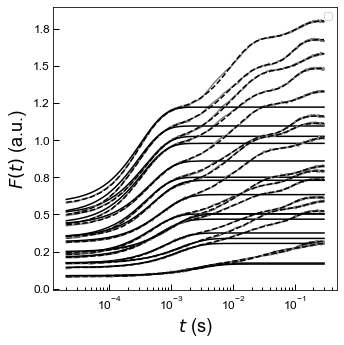

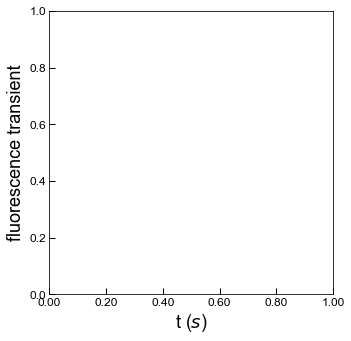

In [16]:
p.figsize = (10, 10)
fig1 = p.set_figure("%e", "%0.1f")
ax1 = plt.gca()
fig2 = p.set_figure("%0.2f", "%0.1f")
ax2 = plt.gca()
tau_list = []
for i, y in enumerate(y_list[:]): 
    
    t = file[keys[0]].values
    ind = t<0.3
    t =t[ind]
    y = y[ind]
    tau, ypred = casual_multiexp(y, t)
    if True:
        ax1.semilogx(t, y, c =  "grey")
        #ax1.annotate(i, (t[5],y[6]), xycoords = "data")
        ax1.semilogx(t, ypred, "--k")


    pos = 3/tau

    pos_tau = find_nearest(t, pos)
    params = get_fit(y[:pos_tau], t[:pos_tau])
    tau_list.append(params[1])
    D = 400
    pos_tau = find_nearest(t, D*params[1])
    #ax2.semilogx(t[:pos_tau*D], y[:pos_tau*D], c="grey")
    ypred =  exp_decay(params, t[:pos_tau*D])
    if True:
        ax1.semilogx(t[:pos_tau*D],ypred, c="k")
    #ax2.annotate(i, (t[0],ypred[1]), xycoords = "data")


    ax1.legend()
    ax1.set_xlabel("$t$ (s)")
    ax1.set_ylabel("$F(t)$ (a.u.)")
    ax2.set_xlabel("t ($s$)")
    ax2.set_ylabel("fluorescence transient")
    #fig1.savefig(p.save_folder + "fits_Yuxi_JC.png")
    #fig2.savefig(p.save_folder + "fits_Yuxi_monoexp.png")


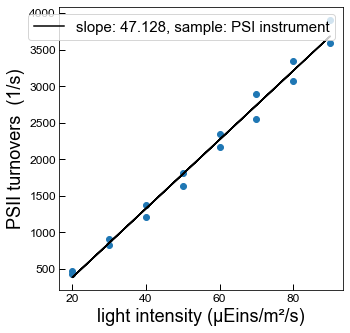

In [17]:
p.figsize=(10,10)
p.xlabel = 'light intensity (µEins/m²/s)'

p.ylabel  = 'PSII turnovers  (1/s)'
fig = p.set_figure("%d", "%d")
Yreg, a_calib, b, pp = regression_affine(np.array(amp_list), 1/np.array(tau_list))
plt.scatter(amp_list, 1/np.array(tau_list))
plt.plot(np.array(amp_list) ,Yreg, '-k', label = "slope: %0.3f, sample: %s"%(a_calib, "PSI instrument"))
plt.legend(prop = {"size":15})
fig.savefig(p.save_folder + "/fits_JC_monoexponential_method.png")

## data yuxi

In [18]:
activated =  np.array([[20,775],
[30,924],
[40,1161],
[50,1482],
[60,1912],
[70,2323],
[80,2777],
[90,3173]])

control = np.array([[90, 3482],
[80,3079],
[70,2610],
[60,2116],
[50,1659],
[40,1208],
[30,938],
[20,890]])

X_instr = np.concatenate([activated[:,0], control[:,0]])
Y_instr = np.concatenate([activated[:,1], control[:,1]])

Text(0, 0.5, 'Fit monoexp sigmoidal on JC-identified segment')

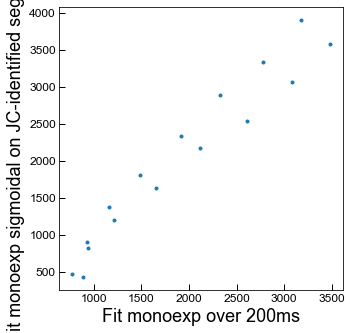

In [19]:

ind_instr = X_instr>0
X_instr = np.array(X_instr)[ind_instr]
Y_instr =  np.array(Y_instr)[ind_instr]
Yreg, a_instr, b, pp = regression_affine(X_instr, Y_instr)

alpha  = 1#a0/a1
p.figsize=(8,8)
fig = p.set_figure("%d", "%d")

tl = tau_list[1:9] + [tau_list[-1]] + [tau_list[0]] +  tau_list[9:15][::-1]

plt.plot(Y_instr ,1/np.array(tl), '.', label = "slope: %0.3f, sample: %s"%(a_instr, "PSII intstrument" ))
plt.xlabel("Fit monoexp over 200ms")
plt.ylabel("Fit monoexp sigmoidal on JC-identified segment")



In [19]:
X_instr

array([20, 30, 40, 50, 60, 70, 80, 90, 90, 80, 70, 60, 50, 40, 30, 20])

[80, 20, 30, 40, 50, 60, 70, 80, 90, 90, 80, 70, 60, 50, 40, 30, 20]